# investigating hypoxic control treatment

this treatment resulted in 3 pairwise comparisons with DMGs - interested if all of these DMGs are unique to hypoxia control (HC)

In [2]:
library(tidyverse)
library(ggvenn)
library(dplyr)
library(RColorBrewer)

###### for KEGG analysis ######
library(topGO)
library(KEGGREST)
library(clusterProfiler)
library(ggridges)
library(httr)

### loading and formatting

In [3]:
# importing csv files

#1 control control vs. hypoxic control
CC_HC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/CC_vs_HC.csv')

#2 control hypoxic vs. hypoxic control
CH_HC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/CH_vs_HC.csv')

#3 hypoxic hypoxic vs. hypoxic control
HH_HC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/HH_vs_HC.csv')

#######################################

#4 hypoxic hypoxic vs. control hypoxic
HH_CH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/HH_vs_CH.csv')

#5 hypoxic hypoxic vs. control control
HH_CC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/CC_vs_HH.csv')

#6 control control vs. control hypoxic
CC_CH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/CC_vs_CH.csv')


pulling out significant DMGs for the three pairwise comparisons with HC (adjusted p-value < 0.05)

In [4]:
# significant DMGs

# 1. control control vs. hypoxic control
sig_CC_HC <- filter(CC_HC, CC_HC$padj < 0.05)
dim(sig_CC_HC) # 20 total sig DMGs

# 2. control hypoxic vs. hypoxic control
sig_CH_HC <- filter(CH_HC, CH_HC$padj < 0.05)
dim(sig_CH_HC) # 258 total sig DMGs

# 3. hypoxic hypoxic vs. hypoxic control
sig_HH_HC <- filter(HH_HC, HH_HC$padj < 0.05)
dim(sig_HH_HC) # 124 total sig DMGs

[1] 12  7

[1] 196   7

[1] 77  7

In [5]:
# significant DMGs

# 4. hypoxic hypoxic vs. control hypoxic
sig_HH_CH <- filter(HH_CH, HH_CH$padj < 0.05)
dim(sig_HH_CH) # 0 total sig DMGs

# 5. hypoxic hypoxic vs. control control
sig_HH_CC <- filter(HH_CC, HH_CC$padj < 0.05)
dim(sig_HH_CC) # 2 total sig DMGs

# 6. control control vs. control hypoxic
sig_CC_CH <- filter(CC_CH, CC_CH$padj < 0.05)
dim(sig_CC_CH) # 1 total sig DMGs

[1] 0 7

[1] 1 7

[1] 1 7

adding columns to the dfs - need to assign which direction the methylation is in order to assign colors in the plots - also adding a column to denote what the pairwise comparison is in case I end up combining dataframes and faceting by this later on... 

In [6]:
# column 'pair' to denote the pairwise comparison this data is originally from 
CC_HC$pair <- 'CC_HC' #1
CH_HC$pair <- 'CH_HC' #2
HH_HC$pair <- 'HH_HC' #3
HH_CH$pair <- 'HH_CH' #4
HH_CC$pair <- 'HH_CC' #5
CC_CH$pair <- 'CC_CH' #6

In [7]:
#1 control control vs. hypoxic control
CC_HC$methyl <- ifelse(CC_HC$log2FoldChange<0 & CC_HC$padj < 0.05, "CC", 
                        ifelse(CC_HC$log2FoldChange>0 & CC_HC$padj < 0.05, "HC", 
                               "not significant"))

#2 control hypoxic vs. hypoxic control
CH_HC$methyl <- ifelse(CH_HC$log2FoldChange<0 & CH_HC$padj < 0.05, "CH", 
                        ifelse(CH_HC$log2FoldChange>0 & CH_HC$padj < 0.05, "HC", 
                               "not significant"))

#3 hypoxic hypoxic vs. hypoxic control
HH_HC$methyl <- ifelse(HH_HC$log2FoldChange<0 & HH_HC$padj < 0.05, "HC", 
                        ifelse(HH_HC$log2FoldChange>0 & HH_HC$padj < 0.05, "HH", 
                               "not significant"))

#4 hypoxic hypoxic vs. control hypoxic
HH_CH$methyl <- ifelse(HH_CH$log2FoldChange<0 & HH_CH$padj < 0.05, "CH",
                        ifelse(HH_CH$log2FoldChange>0 & HH_CH$padj < 0.05, "HH", 
                               "not significant"))

#5 hypoxic hypoxic vs. control control
HH_CC$methyl <- ifelse(HH_CC$log2FoldChange<0 & HH_CC$padj < 0.05, "CC", 
                        ifelse(HH_CC$log2FoldChange>0 & HH_CC$padj < 0.05, "HH", 
                               "not significant"))



#6 control control vs. control hypoxic
CC_CH$methyl <- ifelse(CC_CH$log2FoldChange<0 & CC_CH$padj < 0.05, "CC", 
                        ifelse(CC_CH$log2FoldChange>0 & CC_CH$padj < 0.05, "CH", 
                               "not significant"))


### add gene names/meta data to significant DMGs in pairwise comparisons

From the Index of *C. virginica* genomes/annotations page ([link](https://ftp.ncbi.nlm.nih.gov/genomes/all/annotation_releases/6565/100/GCF_002022765.2_C_virginica-3.0/))

I downloaded the file `GCF_002022765.2_C_virginica-3.0_feature_table` - since only the mRNA lines had gene names (gene products), I first removed empty rows for those and then removed duplicate rows for the gene_id - that csv is what is being loaded here, with the idea that I can provide a list of sig. genes from a pairwise comparison and add gene names to that list

In [8]:
gene_products <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/counts_and_meta/GCF_CV_gene_products.csv')
head(gene_products)

,X..feature,class,assembly,assembly_unit,seq_type,chromosome,genomic_accession,start,end,strand,product_accession,non.redundant_refseq,related_accession,name,symbol,GeneID,locus_tag,feature_interval_length,product_length,attributes
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<int>,<lgl>,<int>,<int>,<chr>
1,gene,lncRNA,GCF_002022765.2,Primary Assembly,chromosome,1,NC_035780.1,13578,14594,+,,NA,,,LOC111116054,111116054,NA,1017,NA,
2,mRNA,,GCF_002022765.2,Primary Assembly,chromosome,1,NC_035780.1,28961,33324,+,XM_022471938.1,NA,XP_022327646.1,UNC5C-like protein,LOC111126949,111126949,NA,2254,2254,
3,mRNA,,GCF_002022765.2,Primary Assembly,chromosome,1,NC_035780.1,43111,66897,-,XM_022447324.1,NA,XP_022303032.1,"FMRFamide receptor-like, transcript variant X1",LOC111110729,111110729,NA,1489,1489,
4,mRNA,,GCF_002022765.2,Primary Assembly,chromosome,1,NC_035780.1,85606,95254,-,XM_022449924.1,NA,XP_022305632.1,homeobox protein Hox-B7-like,LOC111112434,111112434,NA,1023,1023,
5,mRNA,,GCF_002022765.2,Primary Assembly,chromosome,1,NC_035780.1,99840,106460,+,XM_022461698.1,NA,XP_022317406.1,ribulose-phosphate 3-epimerase-like,LOC111120752,111120752,NA,1070,1070,
6,mRNA,,GCF_002022765.2,Primary Assembly,chromosome,1,NC_035780.1,108305,110077,-,XM_022474921.1,NA,XP_022330629.1,mucin-19-like,LOC111128944,111128944,NA,1773,1773,partial


In [9]:
# 1. control control vs. hypoxic control
#gene_products[gene_products$symbol %in% sig_CC_HC$X,]

colnames(sig_CC_HC) <- c('symbol','baseMean','log2FC', 'lfcSE', 'stat','pvalue','padj')

sig_CC_HC_genes <- merge(sig_CC_HC, gene_products, by='symbol')
sig_CC_HC_genes <- select(sig_CC_HC_genes, symbol, baseMean, log2FC, lfcSE, stat, pvalue, padj, name)

write.csv(sig_CC_HC_genes, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/sig_DMGs/sig_CC_HC_genes.csv')


head(sig_CC_HC_genes)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111103344,497.52024,-1.193080,0.2105031,-4.480123,7.460015e-06,0.01869231,"uncharacterized LOC111103344, transcript variant X7"
2,LOC111115023,20.27520,-1.349383,0.2740700,-4.011321,6.038007e-05,0.04126154,uncharacterized LOC111115023
3,LOC111117745,123.41704,-1.135814,0.2070067,-4.279157,1.876021e-05,0.02350342,"uncharacterized LOC111117745, transcript variant X5"
4,LOC111117760,138.87250,-1.494878,0.2901102,-4.291052,1.778290e-05,0.02350342,"disintegrin and metalloproteinase domain-containing protein 10-like, transcript variant X3"
5,LOC111118022,19.27594,-1.664142,0.3486511,-4.056038,4.991215e-05,0.03751897,"exocyst complex component 7-like, transcript variant X1"
6,LOC111119327,13.31739,-1.507178,0.3154716,-3.985075,6.745881e-05,0.04225732,"calcyphosin-like protein, transcript variant X3"


In [10]:
# 2. control hypoxic vs. hypoxic control
colnames(sig_CH_HC) <- c('symbol','baseMean','log2FC', 'lfcSE', 'stat','pvalue','padj')

sig_CH_HC_genes <- merge(sig_CH_HC, gene_products, by='symbol')
sig_CH_HC_genes <- select(sig_CH_HC_genes, symbol, baseMean, log2FC, lfcSE, stat, pvalue, padj, name)

write.csv(sig_CH_HC_genes, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/sig_DMGs/sig_CH_HC_genes.csv')



head(sig_CH_HC_genes)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111099548,42.98619,-1.2672684,0.2026166,-5.020656,5.149523e-07,0.0003099498,kinesin-like protein KIF17
2,LOC111099571,31.11937,-1.4181929,0.2861630,-4.082264,4.459915e-05,0.0069725275,histone RNA hairpin-binding protein-like
3,LOC111099585,36.32548,0.9854391,0.2091056,3.517070,4.363394e-04,0.0332446433,lys-63-specific deubiquitinase BRCC36-like
4,LOC111099930,35.09830,-1.1981548,0.2270953,-4.175140,2.978035e-05,0.0051868387,"uncharacterized LOC111099930, transcript variant X1"
5,LOC111099978,37.23914,1.1530905,0.2612132,3.457293,5.456316e-04,0.0390971051,"oncoprotein-induced transcript 3 protein-like, transcript variant X1"
6,LOC111100608,22.90296,-1.4622657,0.2851646,-4.251109,2.127149e-05,0.0040010349,DDRGK domain-containing protein 1-like


In [11]:
# 3. hypoxic hypoxic vs. hypoxic control
colnames(sig_HH_HC) <- c('symbol','baseMean','log2FC', 'lfcSE', 'stat','pvalue','padj')

sig_HH_HC_genes <- merge(sig_HH_HC, gene_products, by='symbol')
sig_HH_HC_genes <- select(sig_HH_HC_genes, symbol, baseMean, log2FC, lfcSE, stat, pvalue, padj, name)

write.csv(sig_HH_HC_genes, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/sig_DMGs/sig_HH_HC_genes.csv')



head(sig_HH_HC_genes)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111099548,42.98619,1.054197,0.1952758,4.118262,3.817409e-05,0.0119860976,kinesin-like protein KIF17
2,LOC111099571,31.11937,1.583044,0.2784773,4.786904,1.693737e-06,0.0010731159,histone RNA hairpin-binding protein-like
3,LOC111099930,35.09830,1.318024,0.2167696,4.927003,8.350045e-07,0.0007732142,"uncharacterized LOC111099930, transcript variant X1"
4,LOC111100608,22.90296,1.584298,0.2760621,4.833325,1.342715e-06,0.0009508000,DDRGK domain-containing protein 1-like
5,LOC111101237,37.09165,1.078964,0.1927178,4.301443,1.696897e-05,0.0061900739,putative 2'-deoxynucleoside 5'-phosphate N-hydrolase 1
6,LOC111101984,10.15872,1.604290,0.3316931,4.082963,4.446518e-05,0.0130554113,von Willebrand factor D and EGF domain-containing protein-like


4. hypoxic hypoxic vs. control hypoxic

no sig. DMGs


In [12]:
# 5. hypoxic hypoxic vs. control control
colnames(sig_HH_CC) <- c('symbol','baseMean','log2FC', 'lfcSE', 'stat','pvalue','padj')

sig_HH_CC_genes <- merge(sig_HH_CC, gene_products, by='symbol')
sig_HH_CC_genes <- select(sig_HH_CC_genes, symbol, baseMean, log2FC, lfcSE, stat, pvalue, padj, name)

write.csv(sig_HH_CC_genes, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/sig_DMGs/sig_HH_CC_genes.csv')



head(sig_HH_CC_genes)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111100699,13.59616,2.087349,0.3509947,5.234691,1.652615e-07,0.004018332,methylthioribulose-1-phosphate dehydratase-like


In [13]:
# 6. control control vs. control hypoxic
colnames(sig_CC_CH) <- c('symbol','baseMean','log2FC', 'lfcSE', 'stat','pvalue','padj')

sig_CC_CH_genes <- merge(sig_CC_CH, gene_products, by='symbol')
sig_CC_CH_genes <- select(sig_CC_CH_genes, symbol, baseMean, log2FC, lfcSE, stat, pvalue, padj, name)

write.csv(sig_CC_CH_genes, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/sig_DMGs/sig_CC_CH_genes.csv')



head(sig_CC_CH_genes)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111100699,13.59616,1.958284,0.3546143,4.817301,1.455128e-06,0.03538143,methylthioribulose-1-phosphate dehydratase-like


### ggplot Volcano plots 
Volcano plots made with ggplot of the pairwise comparisons from DESeq2

In [14]:
# to change size of plots
options(repr.plot.width=10, repr.plot.height=5)

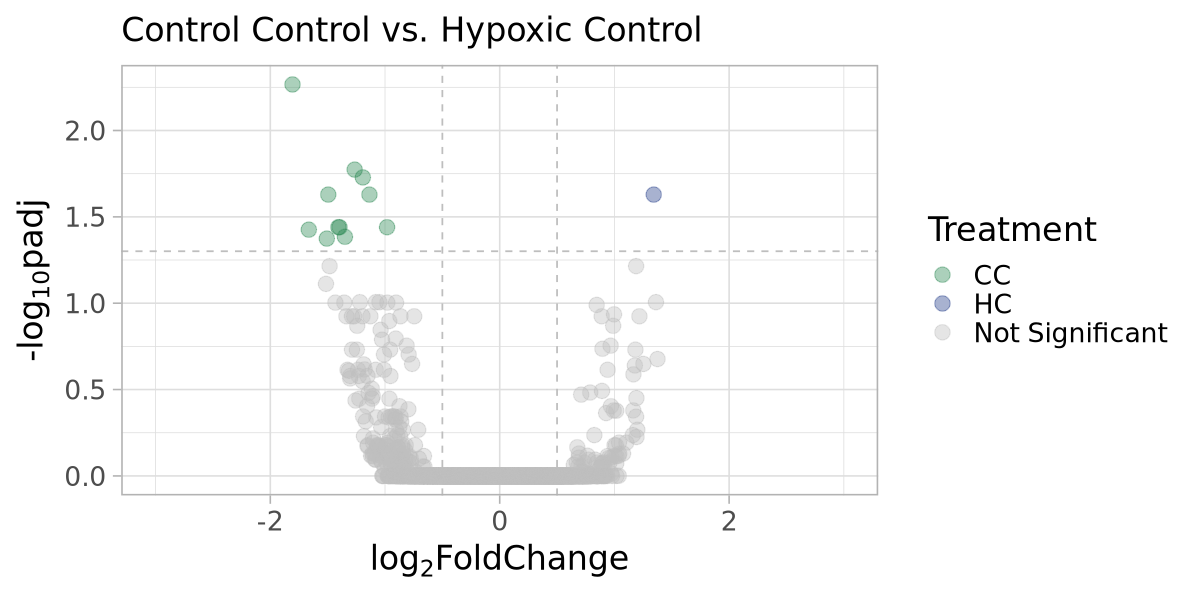

In [15]:
#1 control control vs. hypoxic control
CC_HC <- na.omit(CC_HC) # removing rows with NA for padj

volcano1 <- ggplot(data = CC_HC, aes(x = log2FoldChange,
                                             y = -log10(padj),
                                             col = methyl)) +
                        geom_vline(xintercept = c(-0.5,0.5),
                                   col = "gray",
                                   linetype = 'dashed') + # fold change threshold line
                        geom_hline(yintercept = -log10(0.05), 
                                   col = "gray",
                                   linetype = 'dashed') + # padj threshold line
                        geom_point(size=4, alpha =0.4) +
                        scale_color_manual(values = c('seagreen4','royalblue4', 'gray'),
                                           labels=c('CC', 'HC', 'Not Significant')) + 
                        theme_light(base_size=20) + 
                       labs(subtitle = 'Control Control vs. Hypoxic Control',
                             col='Treatment', 
                             x = expression("log"[2]*"FoldChange"), 
                             y = expression("-log"[10]*"padj")) + 
                        scale_x_continuous(limits = c(-3,3))

volcano1

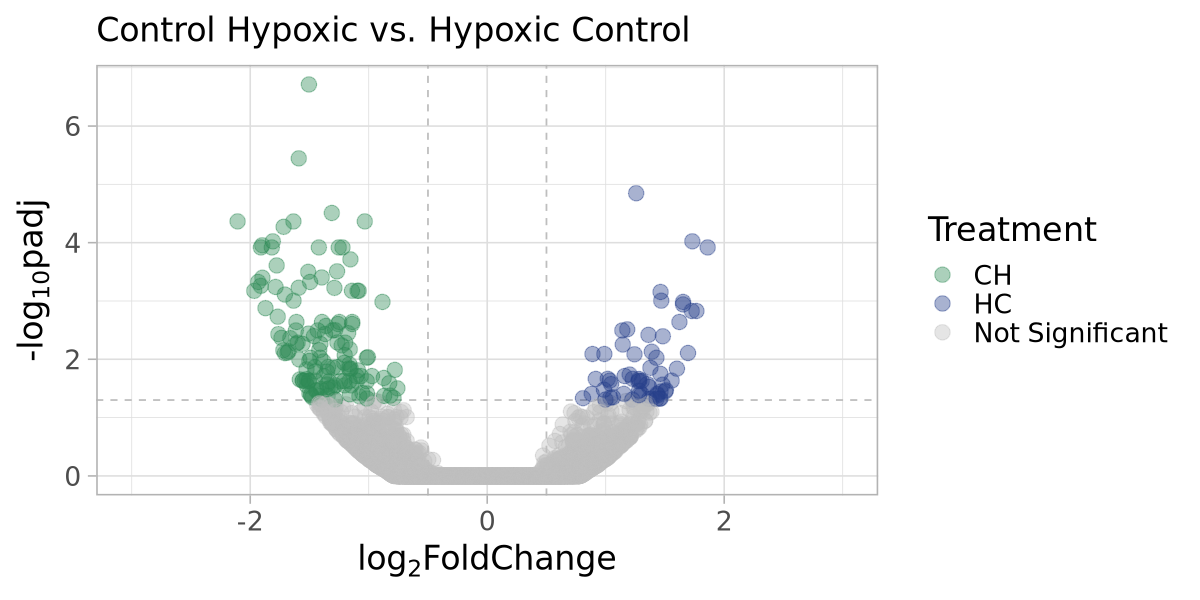

In [16]:
#2 control hypoxic vs. hypoxic control
CH_HC <- na.omit(CH_HC) # removing rows with NA for padj

volcano2 <- ggplot(data = CH_HC, aes(x = log2FoldChange,
                                             y = -log10(padj),
                                             col = methyl)) +
                        geom_vline(xintercept = c(-0.5,0.5),
                                   col = "gray",
                                   linetype = 'dashed') + # fold change threshold line
                        geom_hline(yintercept = -log10(0.05), 
                                   col = "gray",
                                   linetype = 'dashed') + # padj threshold line
                        geom_point(size=4, alpha =0.4) +
                        scale_color_manual(values = c('seagreen4','royalblue4', 'gray'),
                                           labels=c('CH', 'HC', 'Not Significant')) + 
                        theme_light(base_size=20) + 
                        labs(subtitle = 'Control Hypoxic vs. Hypoxic Control',
                             col='Treatment', 
                             x = expression("log"[2]*"FoldChange"), 
                             y = expression("-log"[10]*"padj")) + 
                        scale_x_continuous(limits = c(-3,3))

volcano2

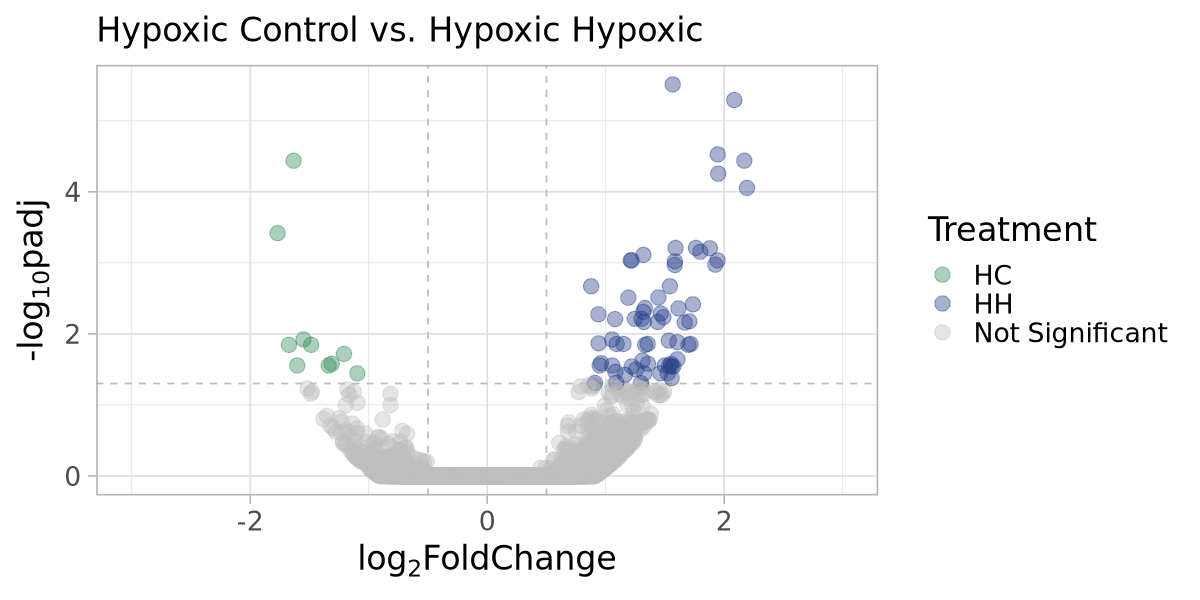

In [17]:
#3 hypoxic hypoxic vs. hypoxic control
HH_HC <- na.omit(HH_HC) # removing rows with NA for padj

volcano3 <- ggplot(data = HH_HC, aes(x = log2FoldChange,
                                             y = -log10(padj),
                                             col = methyl)) +
                        geom_vline(xintercept = c(-0.5,0.5),
                                   col = "gray",
                                   linetype = 'dashed') + # fold change threshold line
                        geom_hline(yintercept = -log10(0.05), 
                                   col = "gray",
                                   linetype = 'dashed') + # padj threshold line
                        geom_point(size=4, alpha =0.4) +
                        scale_color_manual(values = c('seagreen4','royalblue4', 'gray'),
                                           labels=c('HC', 'HH', 'Not Significant')) + 
                        theme_light(base_size=20) + 
                        labs(subtitle = 'Hypoxic Control vs. Hypoxic Hypoxic',
                             col='Treatment', 
                             x = expression("log"[2]*"FoldChange"), 
                             y = expression("-log"[10]*"padj")) + 
                        scale_x_continuous(limits = c(-3,3))

volcano3

want to actually flip the above plot so that HC is on the right and HH is on the left - to do this, make pos. LFC to neg and vice versa

In [18]:
# Switch the signs
HH_HC_flip <- HH_HC %>%
  mutate(log2FoldChange = -log2FoldChange)

HH_HC_flip$methyl <- ifelse(HH_HC_flip$log2FoldChange<0 & HH_HC_flip$padj < 0.05, "HH", 
                        ifelse(HH_HC_flip$log2FoldChange>0 & HH_HC_flip$padj < 0.05, "HC", 
                               "not significant"))

# View the modified dataframe
head(HH_HC_flip)
head(HH_HC)


,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,pair,methyl
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
17,LOC111109452,18.77505,-0.15596788,0.3558042,0.000000,1.0000000000,1.00000000,HH_HC,not significant
18,LOC111124802,217.68988,0.07392689,0.1169430,0.000000,1.0000000000,1.00000000,HH_HC,not significant
19,LOC111101273,79.70594,0.11359457,0.1401031,0.000000,1.0000000000,1.00000000,HH_HC,not significant
20,LOC111101250,127.13666,0.01945303,0.1770973,0.000000,1.0000000000,1.00000000,HH_HC,not significant
21,LOC111101262,278.66598,0.08728262,0.1141343,0.000000,1.0000000000,1.00000000,HH_HC,not significant
22,LOC111133260,47.32761,-0.96099812,0.1844565,3.854558,0.0001159391,0.02584583,HH_HC,HH


,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,pair,methyl
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
17,LOC111109452,18.77505,0.15596788,0.3558042,0.000000,1.0000000000,1.00000000,HH_HC,not significant
18,LOC111124802,217.68988,-0.07392689,0.1169430,0.000000,1.0000000000,1.00000000,HH_HC,not significant
19,LOC111101273,79.70594,-0.11359457,0.1401031,0.000000,1.0000000000,1.00000000,HH_HC,not significant
20,LOC111101250,127.13666,-0.01945303,0.1770973,0.000000,1.0000000000,1.00000000,HH_HC,not significant
21,LOC111101262,278.66598,-0.08728262,0.1141343,0.000000,1.0000000000,1.00000000,HH_HC,not significant
22,LOC111133260,47.32761,0.96099812,0.1844565,3.854558,0.0001159391,0.02584583,HH_HC,HH


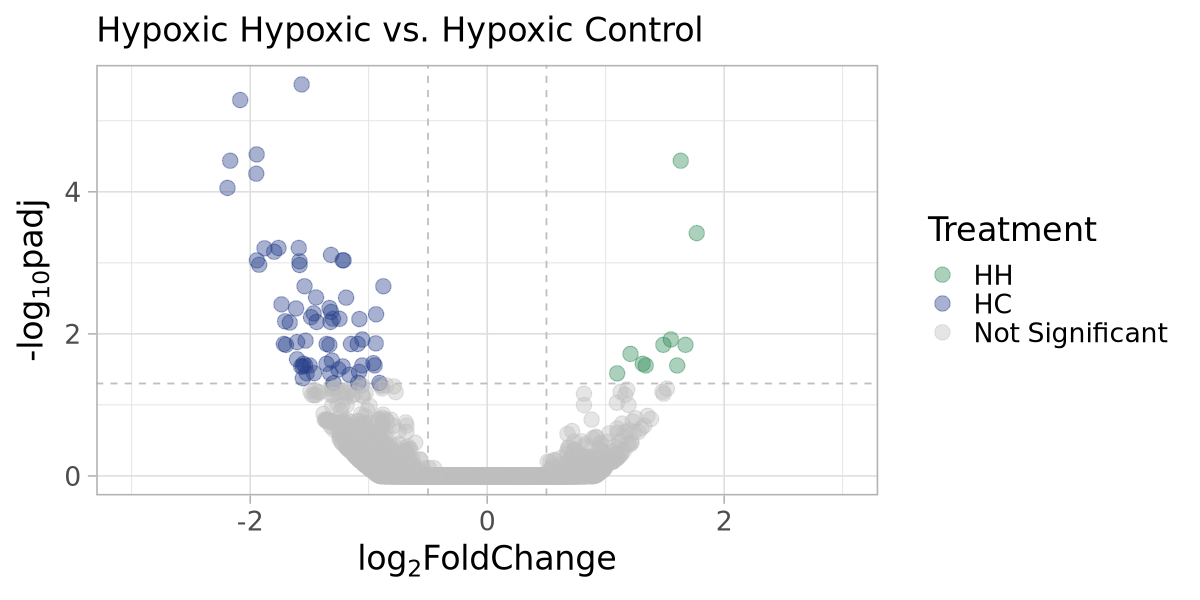

In [19]:
#3 hypoxic hypoxic vs. hypoxic control FLIPPED
volcano3.5 <- ggplot(data = HH_HC_flip, aes(x = log2FoldChange,
                                             y = -log10(padj),
                                             col = methyl)) +
                        geom_vline(xintercept = c(-0.5,0.5),
                                   col = "gray",
                                   linetype = 'dashed') + # fold change threshold line
                        geom_hline(yintercept = -log10(0.05), 
                                   col = "gray",
                                   linetype = 'dashed') + # padj threshold line
                        geom_point(size=4, alpha =0.4) +
                        scale_color_manual(values = c('seagreen4','royalblue4', 'gray'),
                                           labels=c('HH', 'HC', 'Not Significant')) + 
                        theme_light(base_size=20) + 
                        labs(subtitle = 'Hypoxic Hypoxic vs. Hypoxic Control',
                             col='Treatment', 
                             x = expression("log"[2]*"FoldChange"), 
                             y = expression("-log"[10]*"padj")) + 
                        scale_x_continuous(limits = c(-3,3))

volcano3.5

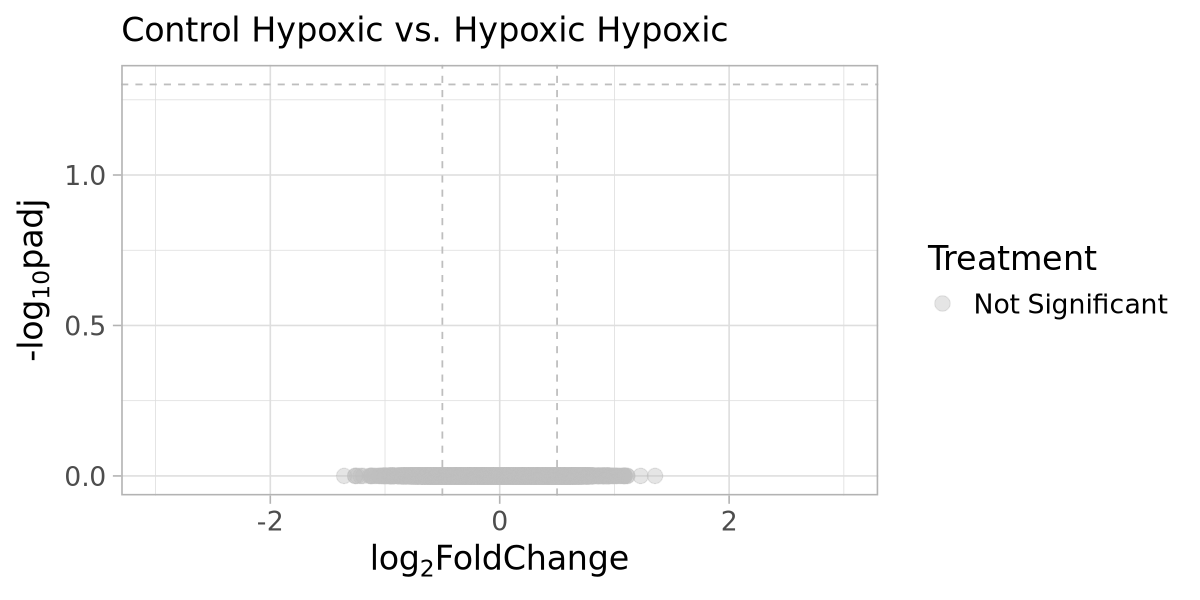

In [20]:
#4 hypoxic hypoxic vs. control hypoxic
HH_CH <- na.omit(HH_CH) # removing rows with NA for padj

volcano4 <- ggplot(data = HH_CH, aes(x = log2FoldChange,
                                             y = -log10(padj),
                                             col = methyl)) +
                        geom_vline(xintercept = c(-0.5,0.5),
                                   col = "gray",
                                   linetype = 'dashed') + # fold change threshold line
                        geom_hline(yintercept = -log10(0.05), 
                                   col = "gray",
                                   linetype = 'dashed') + # padj threshold line
                        geom_point(size=4, alpha =0.4) +
                        scale_color_manual(values = c('gray'),
                                           labels=c('Not Significant')) + 
                        theme_light(base_size=20) + 
                        labs(subtitle = 'Control Hypoxic vs. Hypoxic Hypoxic',
                             col='Treatment', 
                             x = expression("log"[2]*"FoldChange"), 
                             y = expression("-log"[10]*"padj")) + 
                        scale_x_continuous(limits = c(-3,3))

volcano4

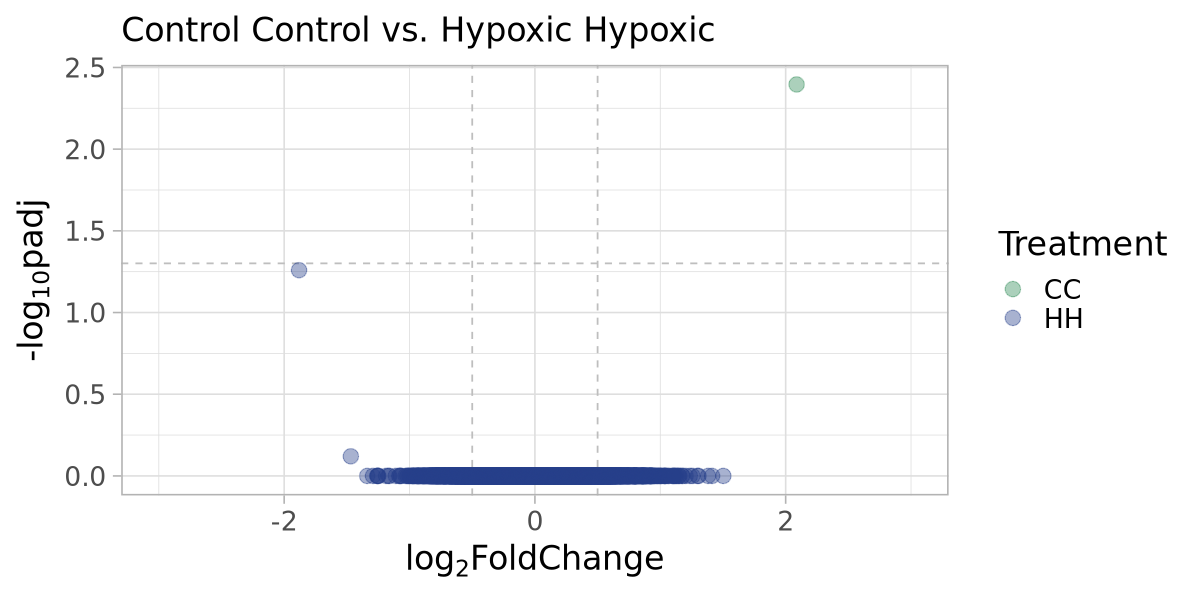

In [21]:
#5 hypoxic hypoxic vs. control control
HH_CC <- na.omit(HH_CC) # removing rows with NA for padj

volcano5 <- ggplot(data = HH_CC, aes(x = log2FoldChange,
                                             y = -log10(padj),
                                             col = methyl)) +
                        geom_vline(xintercept = c(-0.5,0.5),
                                   col = "gray",
                                   linetype = 'dashed') + # fold change threshold line
                        geom_hline(yintercept = -log10(0.05), 
                                   col = "gray",
                                   linetype = 'dashed') + # padj threshold line
                        geom_point(size=4, alpha =0.4) +
                        scale_color_manual(values = c('seagreen4','royalblue4', 'gray'),
                                           labels=c('CC', 'HH', 'Not Significant')) + 
                        theme_light(base_size=20) + 
                        labs(subtitle = 'Control Control vs. Hypoxic Hypoxic',
                             col='Treatment', 
                             x = expression("log"[2]*"FoldChange"), 
                             y = expression("-log"[10]*"padj")) + 
                        scale_x_continuous(limits = c(-3,3))

volcano5

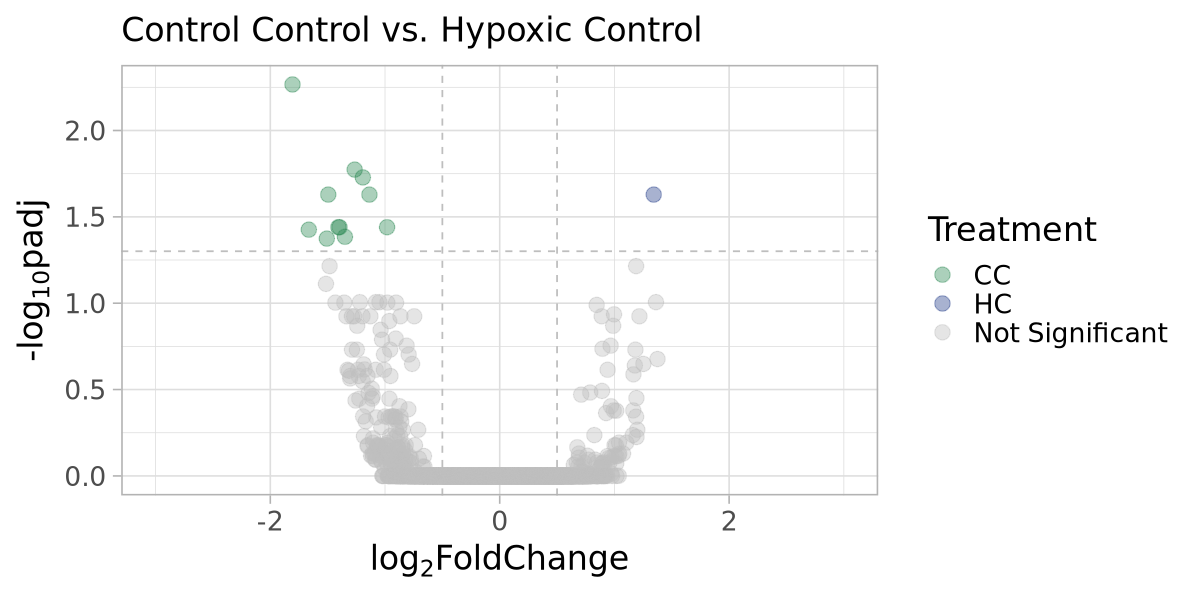

In [22]:
#6 control control vs. control hypoxic
CC_HC <- na.omit(CC_HC) # removing rows with NA for padj

volcano6 <- ggplot(data = CC_HC, aes(x = log2FoldChange,
                                             y = -log10(padj),
                                             col = methyl)) +
                        geom_vline(xintercept = c(-0.5,0.5),
                                   col = "gray",
                                   linetype = 'dashed') + # fold change threshold line
                        geom_hline(yintercept = -log10(0.05), 
                                   col = "gray",
                                   linetype = 'dashed') + # padj threshold line
                        geom_point(size=4, alpha =0.4) +
                        scale_color_manual(values = c('seagreen4','royalblue4', 'gray'),
                                           labels=c('CC', 'HC', 'Not Significant')) + 
                        theme_light(base_size=20) + 
                        labs(subtitle = 'Control Control vs. Hypoxic Control',
                             col='Treatment', 
                             x = expression("log"[2]*"FoldChange"), 
                             y = expression("-log"[10]*"padj")) + 
                        scale_x_continuous(limits = c(-3,3))

volcano6

putting all the data together into one ggplot grid...

In [23]:
mega_df <- na.omit(rbind(CC_HC, CH_HC, HH_HC_flip, HH_CH, HH_CC, CC_CH))
head(mega_df)

,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,pair,methyl
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
17,LOC111109452,18.77505,-0.16226559,0.3575755,0.000000,1.0000000000,1.0000000,CC_HC,not significant
18,LOC111124802,217.68988,0.09050737,0.1234114,0.000000,1.0000000000,1.0000000,CC_HC,not significant
19,LOC111101273,79.70594,-0.11280505,0.1483744,0.000000,1.0000000000,1.0000000,CC_HC,not significant
20,LOC111101250,127.13666,-0.13336153,0.1830605,0.000000,1.0000000000,1.0000000,CC_HC,not significant
21,LOC111101262,278.66598,0.19233094,0.1201891,0.000000,1.0000000000,1.0000000,CC_HC,not significant
22,LOC111133260,47.32761,-0.90652990,0.1964406,-3.342129,0.0008313848,0.1602441,CC_HC,not significant


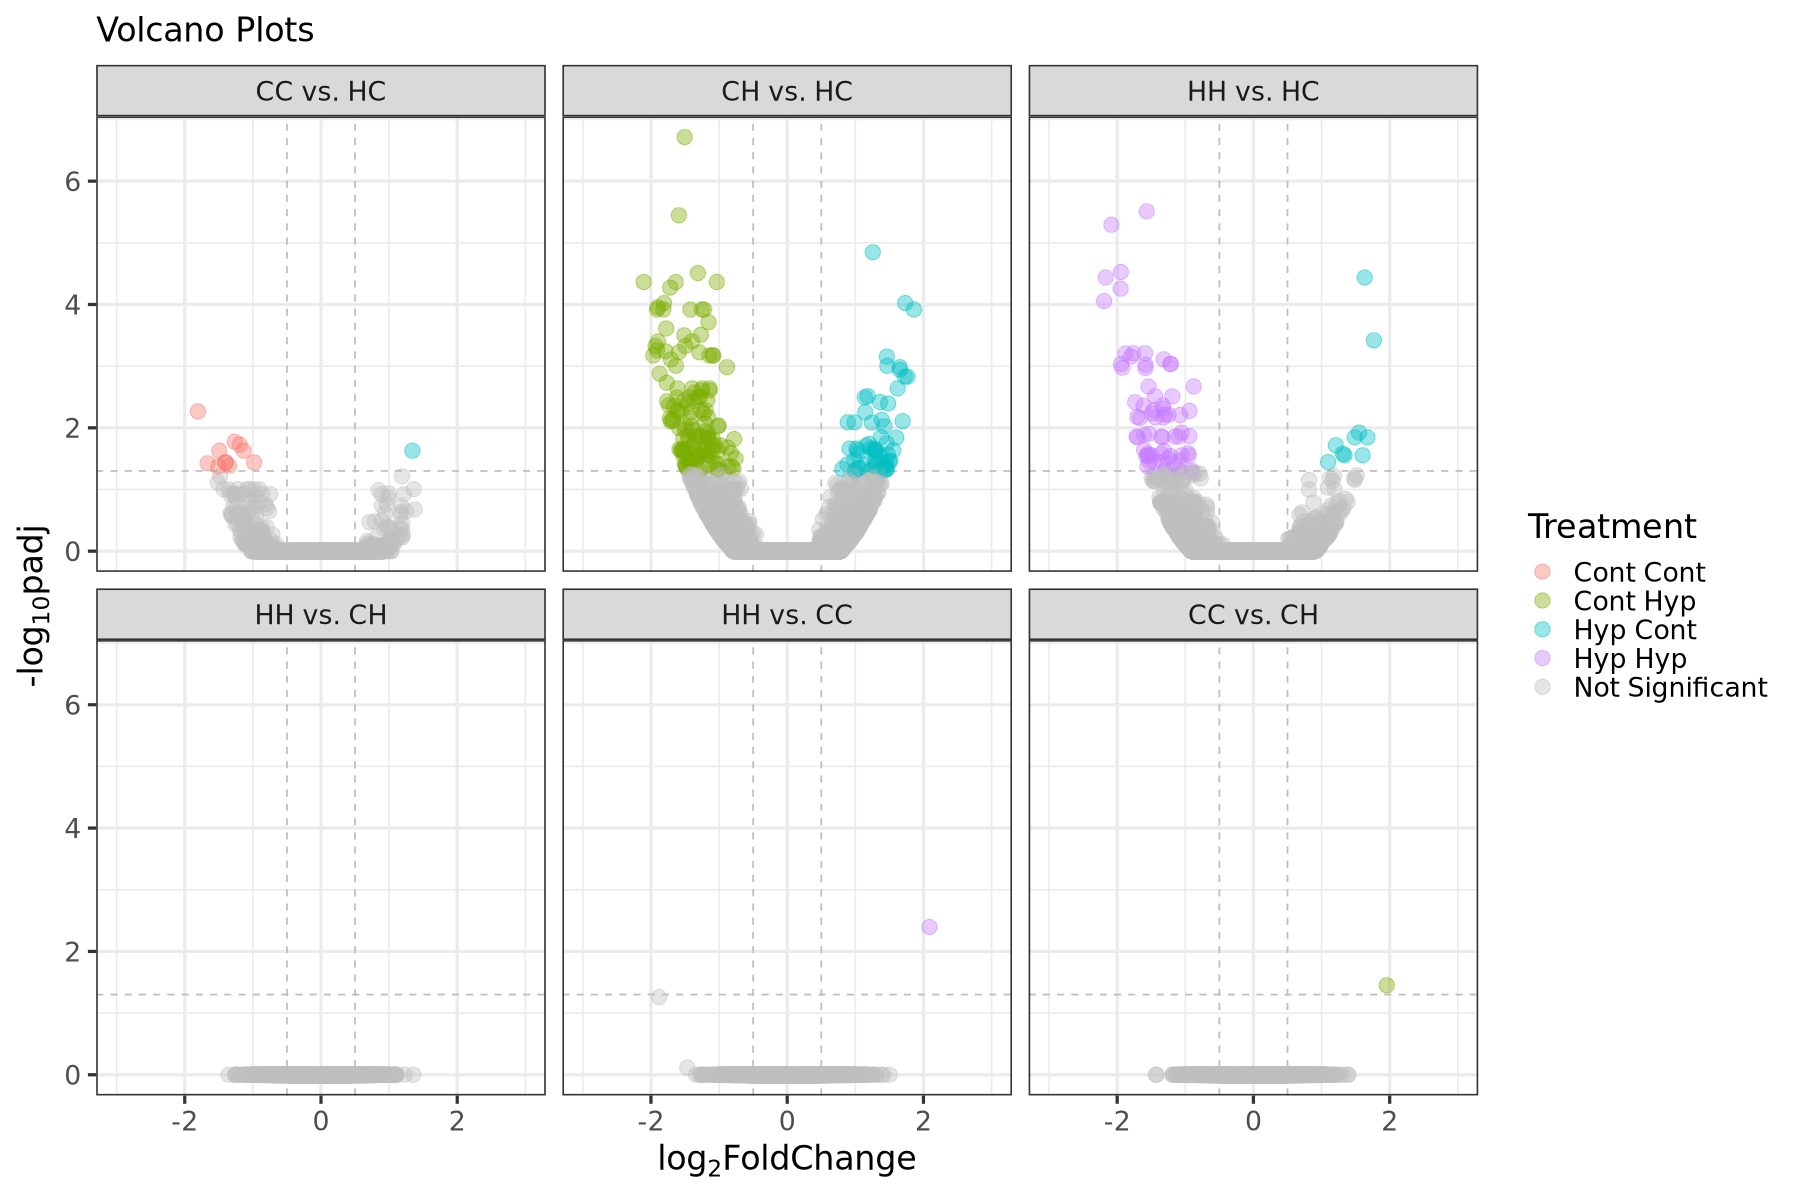

In [24]:
options(repr.plot.width=15, repr.plot.height=10)

# setting order of grids for facet_wrap
mega_df$pair <- factor(mega_df$pair, levels = c('CC_HC','CH_HC','HH_HC', 'HH_CH','HH_CC','CC_CH'))

# renaming grid labels
new_labels <- c(CC_HC = "CC vs. HC", 
                CH_HC = "CH vs. HC", 
                HH_HC = "HH vs. HC",
               HH_CH = "HH vs. CH",
               HH_CC = "HH vs. CC",
               CC_CH = "CC vs. CH")

volcano_MEGA <- ggplot(data = mega_df, aes(x = log2FoldChange,
                                             y = -log10(padj),
                                             col = methyl)) +
                        geom_vline(xintercept = c(-0.5,0.5),
                                   col = "gray",
                                   linetype = 'dashed') + # fold change threshold line
                        geom_hline(yintercept = -log10(0.05), 
                                   col = "gray",
                                   linetype = 'dashed') + # padj threshold line
                        geom_point(size=4, alpha =0.4) +
scale_color_manual(values = c('#F8766D','#7CAE00', '#00BFC4', '#C77CFF', 'gray'),
                                           labels=c('Cont Cont','Cont Hyp', 'Hyp Cont', 'Hyp Hyp', 'Not Significant')) + 
facet_wrap(~pair, labeller = as_labeller(new_labels)) + 
                        theme_bw(base_size=20) + 
                        labs(subtitle = 'Volcano Plots',
                             col='Treatment', 
                             x = expression("log"[2]*"FoldChange"), 
                             y = expression("-log"[10]*"padj")) + 
                        scale_x_continuous(limits = c(-3,3))

volcano_MEGA

just adding another option for how things are labelled

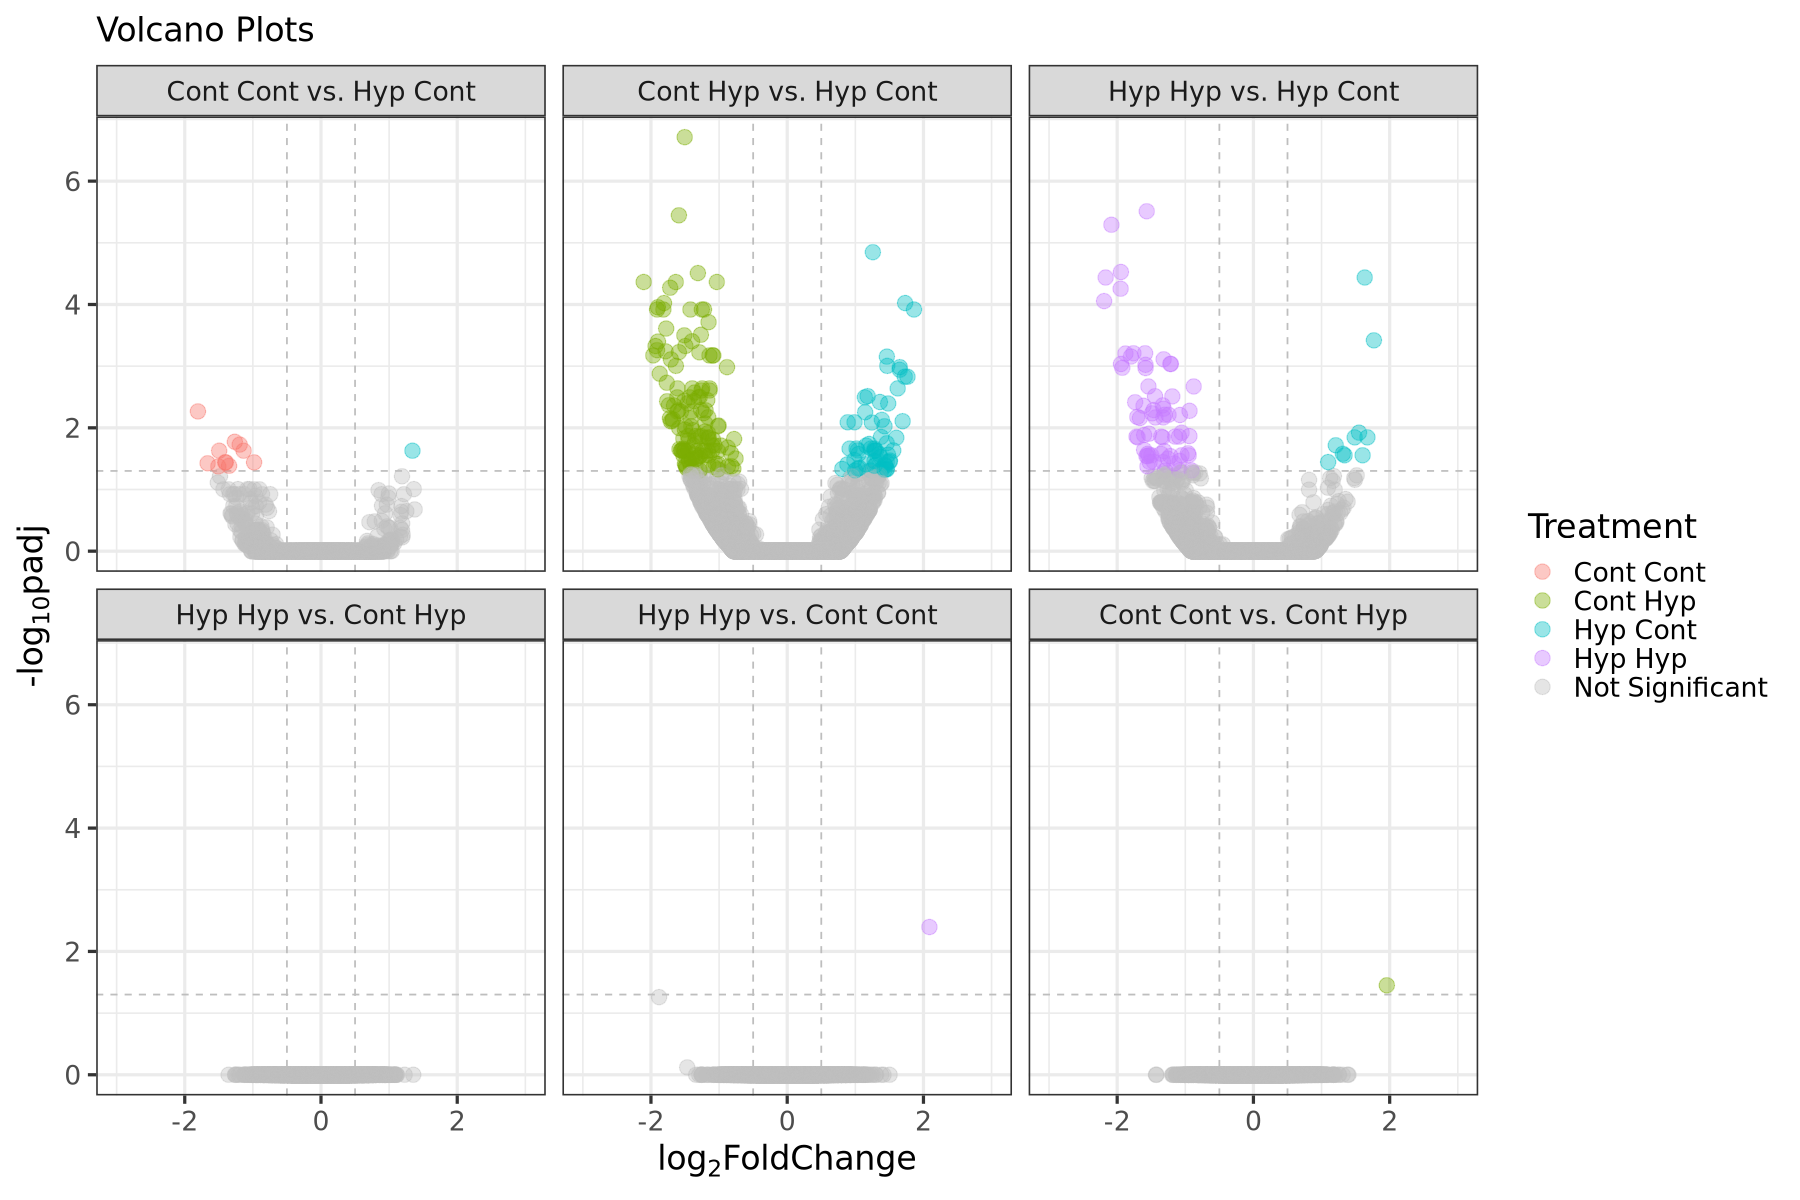

In [25]:
options(repr.plot.width=15, repr.plot.height=10)

# setting order of grids for facet_wrap
mega_df$pair <- factor(mega_df$pair, levels = c('CC_HC','CH_HC','HH_HC', 'HH_CH','HH_CC','CC_CH'))

# renaming grid labels
new_labels <- c(CC_HC = "Cont Cont vs. Hyp Cont", 
                CH_HC = "Cont Hyp vs. Hyp Cont", 
                HH_HC = "Hyp Hyp vs. Hyp Cont",
               HH_CH = "Hyp Hyp vs. Cont Hyp",
               HH_CC = "Hyp Hyp vs. Cont Cont",
               CC_CH = "Cont Cont vs. Cont Hyp")

volcano_MEGA <- ggplot(data = mega_df, aes(x = log2FoldChange,
                                             y = -log10(padj),
                                             col = methyl)) +
                        geom_vline(xintercept = c(-0.5,0.5),
                                   col = "gray",
                                   linetype = 'dashed') + # fold change threshold line
                        geom_hline(yintercept = -log10(0.05), 
                                   col = "gray",
                                   linetype = 'dashed') + # padj threshold line
                        geom_point(size=4, alpha =0.4) +
scale_color_manual(values = c('#F8766D','#7CAE00', '#00BFC4', '#C77CFF', 'gray'),
                                           labels=c('Cont Cont','Cont Hyp', 'Hyp Cont', 'Hyp Hyp', 'Not Significant')) + 
facet_wrap(~pair, labeller = as_labeller(new_labels)) + 
                        theme_bw(base_size=20) + 
                        labs(subtitle = 'Volcano Plots',
                             col='Treatment', 
                             x = expression("log"[2]*"FoldChange"), 
                             y = expression("-log"[10]*"padj")) + 
                        scale_x_continuous(limits = c(-3,3))

volcano_MEGA

### Venn diagram of all sig. DMGs

In [26]:

x = list(A = sig_CC_HC$symbol,
         B = sig_CH_HC$symbol, 
         C = sig_HH_HC$symbol)

names(x) <- c('CC vs. HC',
              'CH vs. HC',
              'HH vs. HC')

# same colors as used in the volcano plots
custom_colors <- c('#F8766D',  '#7CAE00', '#C77CFF')

png(filename="/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/venn_genes/venn_diagram.png")


ggvenn(x,
      set_name_size = 6,
       text_size = 7,
      stroke_size = 0.5, 
       show_percentage = TRUE,
      fill_color = custom_colors)

dev.off()

png 
  2

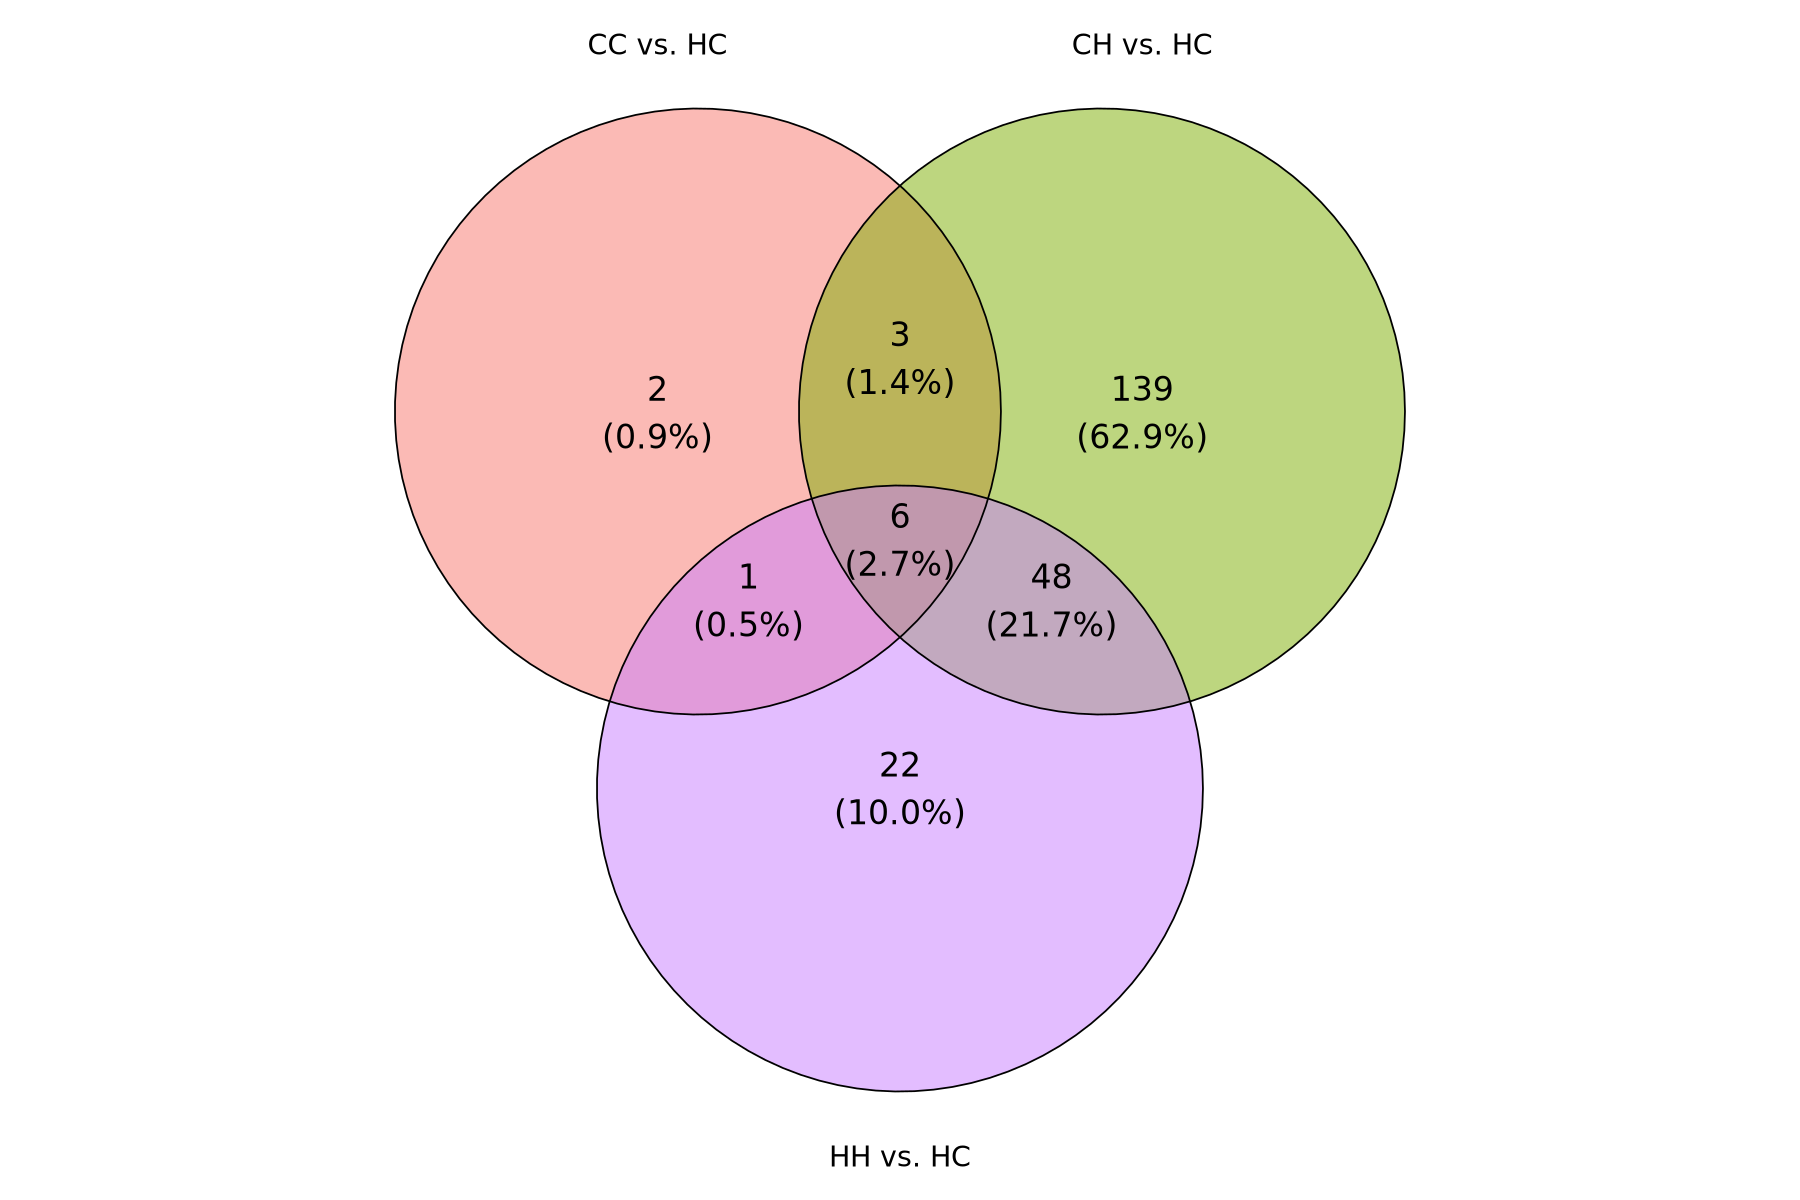

In [27]:
ggvenn(x,
      set_name_size = 6,
       text_size = 7,
      stroke_size = 0.5, 
       show_percentage = TRUE,
      fill_color = custom_colors)

### shared sig DMGs for the pairwise comparisons

In [28]:
# pulling out the 14 shared genes

# Merge the data frames on the 'gene' column
shared_genes6 <- Reduce(function(x, y) merge(x, y, by = "symbol"), list(sig_CC_HC_genes, sig_CH_HC_genes, sig_HH_HC_genes))

shared_genes6 <- as.data.frame(shared_genes6)
                    
# View the result
dim(shared_genes6)


[1]  6 22

In [29]:
shared_genes6

symbol,baseMean.x,log2FC.x,lfcSE.x,stat.x,pvalue.x,padj.x,name.x,baseMean.y,log2FC.y,⋯,pvalue.y,padj.y,name.y,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
LOC111117760,138.87250,-1.494878,0.2901102,-4.291052,1.778290e-05,0.023503416,"disintegrin and metalloproteinase domain-containing protein 10-like, transcript variant X3",138.87250,-1.351404,⋯,1.504690e-04,1.631844e-02,"disintegrin and metalloproteinase domain-containing protein 10-like, transcript variant X3",138.87250,1.356759,0.2882152,3.840044,1.230124e-04,2.639809e-02,"disintegrin and metalloproteinase domain-containing protein 10-like, transcript variant X3"
LOC111119327,13.31739,-1.507178,0.3154716,-3.985075,6.745881e-05,0.042257323,"calcyphosin-like protein, transcript variant X3",13.31739,-1.898432,⋯,1.012038e-07,1.107538e-04,"calcyphosin-like protein, transcript variant X3",13.31739,2.084902,0.2990502,6.135765,8.475033e-10,5.101122e-06,"calcyphosin-like protein, transcript variant X3"
LOC111123492,43.91933,-1.264591,0.2211555,-4.587681,4.481962e-06,0.016845456,"pre-B-cell leukemia transcription factor 1-like, transcript variant X11",43.91933,-1.590124,⋯,5.947551e-10,3.579831e-06,"pre-B-cell leukemia transcription factor 1-like, transcript variant X11",43.91933,1.565953,0.2081032,6.323557,2.556094e-10,3.077026e-06,"pre-B-cell leukemia transcription factor 1-like, transcript variant X11"
LOC111124674,17.57497,-1.406706,0.2805413,-4.123123,3.737706e-05,0.036303375,"gamma-glutamyltranspeptidase 1-like, transcript variant X1",17.57497,-1.408187,⋯,3.273030e-05,5.438185e-03,"gamma-glutamyltranspeptidase 1-like, transcript variant X1",17.57497,1.589960,0.2664452,5.029027,4.929756e-07,6.171045e-04,"gamma-glutamyltranspeptidase 1-like, transcript variant X1"
LOC111129146,22.23491,1.342719,0.2551562,4.282548,1.847653e-05,0.023503416,FERM domain-containing protein 8-like,22.23491,1.463103,⋯,1.978316e-06,7.004403e-04,FERM domain-containing protein 8-like,22.23491,-1.633663,0.2432214,-5.688903,1.278579e-08,3.651925e-05,FERM domain-containing protein 8-like
LOC111133438,21.61303,-1.806478,0.3140663,-4.955889,7.200032e-07,0.005412264,uncharacterized LOC111133438,21.61303,-1.558558,⋯,3.297786e-05,5.438185e-03,uncharacterized LOC111133438,21.61303,1.949220,0.3058639,5.555479,2.768520e-08,5.554574e-05,uncharacterized LOC111133438


all of these except for LOC111133438 were in the original analysis - should make a venn diagram of overlap between exon features-to-meta features and new analysis with gene body methylation

In [30]:
write.csv(shared_genes6, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/venn_genes/6shared_genes.csv')

pulling out the **54 shared genes between HH vs. HC and CH vs. HC**

In [31]:
# pulling out the 54 shared genes

# Merge the data frames on the 'gene' column
shared_genes54 <- Reduce(function(x, y) merge(x, y, by = "symbol"), list(sig_CH_HC_genes, sig_HH_HC_genes))
                    
shared_genes54 <- as.data.frame(shared_genes54)

# View the result
dim(shared_genes54)


[1] 54 15

In [32]:
head(shared_genes54)

,symbol,baseMean.x,log2FC.x,lfcSE.x,stat.x,pvalue.x,padj.x,name.x,baseMean.y,log2FC.y,lfcSE.y,stat.y,pvalue.y,padj.y,name.y
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111099548,42.98619,-1.267268,0.2026166,-5.020656,5.149523e-07,0.0003099498,kinesin-like protein KIF17,42.98619,1.054197,0.1952758,4.118262,3.817409e-05,0.0119860976,kinesin-like protein KIF17
2,LOC111099571,31.11937,-1.418193,0.2861630,-4.082264,4.459915e-05,0.0069725275,histone RNA hairpin-binding protein-like,31.11937,1.583044,0.2784773,4.786904,1.693737e-06,0.0010731159,histone RNA hairpin-binding protein-like
3,LOC111099930,35.09830,-1.198155,0.2270953,-4.175140,2.978035e-05,0.0051868387,"uncharacterized LOC111099930, transcript variant X1",35.09830,1.318024,0.2167696,4.927003,8.350045e-07,0.0007732142,"uncharacterized LOC111099930, transcript variant X1"
4,LOC111100608,22.90296,-1.462266,0.2851646,-4.251109,2.127149e-05,0.0040010349,DDRGK domain-containing protein 1-like,22.90296,1.584298,0.2760621,4.833325,1.342715e-06,0.0009508000,DDRGK domain-containing protein 1-like
5,LOC111101237,37.09165,-1.139884,0.2019498,-4.406461,1.050732e-05,0.0024801387,putative 2'-deoxynucleoside 5'-phosphate N-hydrolase 1,37.09165,1.078964,0.1927178,4.301443,1.696897e-05,0.0061900739,putative 2'-deoxynucleoside 5'-phosphate N-hydrolase 1
6,LOC111101984,10.15872,-1.767496,0.3372300,-4.499884,6.799068e-06,0.0018601633,von Willebrand factor D and EGF domain-containing protein-like,10.15872,1.604290,0.3316931,4.082963,4.446518e-05,0.0130554113,von Willebrand factor D and EGF domain-containing protein-like


pulling out the **48 genes shared ONLY between HH vs. HC and CH vs. HC**

In [33]:
# to remove the 6 genes that are shared between all the comparisons, and to only look at those shared between just these two...
shared_genes48 <- shared_genes54[!shared_genes54$symbol %in% shared_genes6$symbol, ]
dim(shared_genes48)

[1] 48 15

In [34]:
head(shared_genes48)

,symbol,baseMean.x,log2FC.x,lfcSE.x,stat.x,pvalue.x,padj.x,name.x,baseMean.y,log2FC.y,lfcSE.y,stat.y,pvalue.y,padj.y,name.y
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111099548,42.98619,-1.267268,0.2026166,-5.020656,5.149523e-07,0.0003099498,kinesin-like protein KIF17,42.98619,1.054197,0.1952758,4.118262,3.817409e-05,0.0119860976,kinesin-like protein KIF17
2,LOC111099571,31.11937,-1.418193,0.2861630,-4.082264,4.459915e-05,0.0069725275,histone RNA hairpin-binding protein-like,31.11937,1.583044,0.2784773,4.786904,1.693737e-06,0.0010731159,histone RNA hairpin-binding protein-like
3,LOC111099930,35.09830,-1.198155,0.2270953,-4.175140,2.978035e-05,0.0051868387,"uncharacterized LOC111099930, transcript variant X1",35.09830,1.318024,0.2167696,4.927003,8.350045e-07,0.0007732142,"uncharacterized LOC111099930, transcript variant X1"
4,LOC111100608,22.90296,-1.462266,0.2851646,-4.251109,2.127149e-05,0.0040010349,DDRGK domain-containing protein 1-like,22.90296,1.584298,0.2760621,4.833325,1.342715e-06,0.0009508000,DDRGK domain-containing protein 1-like
5,LOC111101237,37.09165,-1.139884,0.2019498,-4.406461,1.050732e-05,0.0024801387,putative 2'-deoxynucleoside 5'-phosphate N-hydrolase 1,37.09165,1.078964,0.1927178,4.301443,1.696897e-05,0.0061900739,putative 2'-deoxynucleoside 5'-phosphate N-hydrolase 1
6,LOC111101984,10.15872,-1.767496,0.3372300,-4.499884,6.799068e-06,0.0018601633,von Willebrand factor D and EGF domain-containing protein-like,10.15872,1.604290,0.3316931,4.082963,4.446518e-05,0.0130554113,von Willebrand factor D and EGF domain-containing protein-like


In [35]:
write.csv(shared_genes48, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/venn_genes/48shared_genes.csv')

pulling out the **9 genes shared bewteen CC vs. HC and CH vs. HC**

In [36]:
# pulling out the 9 shared genes

# Merge the data frames on the 'gene' column
shared_genes9 <- Reduce(function(x, y) merge(x, y, by = "symbol"), list(sig_CC_HC_genes, sig_CH_HC_genes))  
shared_genes9 <- as.data.frame(shared_genes9)

dim(shared_genes9)

[1]  9 15

In [37]:
head(shared_genes9)

,symbol,baseMean.x,log2FC.x,lfcSE.x,stat.x,pvalue.x,padj.x,name.x,baseMean.y,log2FC.y,lfcSE.y,stat.y,pvalue.y,padj.y,name.y
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111103344,497.52024,-1.193080,0.2105031,-4.480123,7.460015e-06,0.01869231,"uncharacterized LOC111103344, transcript variant X7",497.52024,-1.016149,0.2108982,-3.632792,2.803705e-04,2.376831e-02,"uncharacterized LOC111103344, transcript variant X7"
2,LOC111117760,138.87250,-1.494878,0.2901102,-4.291052,1.778290e-05,0.02350342,"disintegrin and metalloproteinase domain-containing protein 10-like, transcript variant X3",138.87250,-1.351404,0.2905854,-3.790294,1.504690e-04,1.631844e-02,"disintegrin and metalloproteinase domain-containing protein 10-like, transcript variant X3"
3,LOC111119327,13.31739,-1.507178,0.3154716,-3.985075,6.745881e-05,0.04225732,"calcyphosin-like protein, transcript variant X3",13.31739,-1.898432,0.3095909,-5.324549,1.012038e-07,1.107538e-04,"calcyphosin-like protein, transcript variant X3"
4,LOC111123492,43.91933,-1.264591,0.2211555,-4.587681,4.481962e-06,0.01684546,"pre-B-cell leukemia transcription factor 1-like, transcript variant X11",43.91933,-1.590124,0.2164348,-6.191815,5.947551e-10,3.579831e-06,"pre-B-cell leukemia transcription factor 1-like, transcript variant X11"
5,LOC111124674,17.57497,-1.406706,0.2805413,-4.123123,3.737706e-05,0.03630337,"gamma-glutamyltranspeptidase 1-like, transcript variant X1",17.57497,-1.408187,0.2788402,-4.153588,3.273030e-05,5.438185e-03,"gamma-glutamyltranspeptidase 1-like, transcript variant X1"
6,LOC111129146,22.23491,1.342719,0.2551562,4.282548,1.847653e-05,0.02350342,FERM domain-containing protein 8-like,22.23491,1.463103,0.2550880,4.755627,1.978316e-06,7.004403e-04,FERM domain-containing protein 8-like


pulling out the **3 genes shared between ONLY CC vs. HC and CH vs. HC**

In [38]:
# to remove the 3 genes that are shared between all the comparisons, and to only look at those shared between just these two...
shared_genes3 <- shared_genes9[!shared_genes9$symbol %in% shared_genes6$symbol, ]
dim(shared_genes3)

[1]  3 15

In [39]:
head(shared_genes3)

,symbol,baseMean.x,log2FC.x,lfcSE.x,stat.x,pvalue.x,padj.x,name.x,baseMean.y,log2FC.y,lfcSE.y,stat.y,pvalue.y,padj.y,name.y
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111103344,497.52024,-1.1930798,0.2105031,-4.480123,7.460015e-06,0.01869231,"uncharacterized LOC111103344, transcript variant X7",497.52024,-1.016149,0.2108982,-3.632792,2.803705e-04,0.0237683108,"uncharacterized LOC111103344, transcript variant X7"
7,LOC111132100,25.78011,-1.3964117,0.2804168,-4.088242,4.346553e-05,0.03630337,"uncharacterized LOC111132100, transcript variant X3",25.78011,-1.590381,0.2776263,-4.828004,1.379080e-06,0.0005929060,"uncharacterized LOC111132100, transcript variant X3"
9,LOC111133874,106.76763,-0.9820156,0.1780116,-4.112179,3.919417e-05,0.03630337,uncharacterized LOC111133874,106.76763,-1.154486,0.1763009,-5.130353,2.891988e-07,0.0001934097,uncharacterized LOC111133874


In [40]:
write.csv(shared_genes3, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/venn_genes/3shared_genes.csv')

In [41]:
shared_gene7 <- Reduce(function(x, y) merge(x, y, by = "symbol"), list(sig_CC_HC_genes, sig_HH_HC_genes))
shared_gene1 <- shared_gene7[!shared_gene7$symbol %in% shared_genes6$symbol, ]                     
dim(shared_gene1)

[1]  1 15

In [42]:
shared_gene1

,symbol,baseMean.x,log2FC.x,lfcSE.x,stat.x,pvalue.x,padj.x,name.x,baseMean.y,log2FC.y,lfcSE.y,stat.y,pvalue.y,padj.y,name.y
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2,LOC111118022,19.27594,-1.664142,0.3486511,-4.056038,4.991215e-05,0.03751897,"exocyst complex component 7-like, transcript variant X1",19.27594,1.556436,0.3455086,3.781196,0.000156077,0.02870595,"exocyst complex component 7-like, transcript variant X1"


### unique sig DMGs for pairwise comparison

pulling out the **173 unique sig DMGs for CH vs. HC**

In [43]:
unique_CH_HC <- sig_CH_HC_genes[!sig_CH_HC_genes$symbol %in% c(shared_genes6$symbol, shared_genes3$symbol, shared_genes48$symbol), ]
dim(unique_CH_HC)

[1] 136   8

In [44]:
head(unique_CH_HC)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
3,LOC111099585,36.32548,0.9854391,0.2091056,3.517070,4.363394e-04,0.033244643,lys-63-specific deubiquitinase BRCC36-like
5,LOC111099978,37.23914,1.1530905,0.2612132,3.457293,5.456316e-04,0.039097105,"oncoprotein-induced transcript 3 protein-like, transcript variant X1"
7,LOC111100625,38.39518,-1.2060788,0.2621809,-3.646638,2.656942e-04,0.023517848,"succinate dehydrogenase [ubiquinone] flavoprotein subunit, mitochondrial-like, transcript variant X2"
8,LOC111100898,38.34191,-1.3046636,0.2438064,-4.325825,1.519623e-05,0.003201238,"uncharacterized LOC111100898, transcript variant X3"
9,LOC111100915,20.55756,1.6529072,0.3015883,4.651730,3.291615e-06,0.001037820,"uncharacterized LOC111100915, transcript variant X2"
11,LOC111101375,40.32033,-1.2280407,0.2367017,-4.131955,3.596914e-05,0.005773287,mu-type opioid receptor-like


In [45]:
write.csv(unique_CH_HC, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/venn_genes/139unique_genes_CHvHC.csv')

pulling out the **2 unique sig DMGs for CC vs. HC**

In [46]:
unique_CC_HC <- sig_CC_HC_genes[!sig_CC_HC_genes$symbol %in% c(shared_genes6$symbol, shared_genes3$symbol, shared_gene1$symbol), ]
dim(unique_CC_HC)

[1] 2 8

In [47]:
head(unique_CC_HC)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2,LOC111115023,20.2752,-1.349383,0.2740700,-4.011321,6.038007e-05,0.04126154,uncharacterized LOC111115023
3,LOC111117745,123.4170,-1.135814,0.2070067,-4.279157,1.876021e-05,0.02350342,"uncharacterized LOC111117745, transcript variant X5"


In [48]:
write.csv(unique_CC_HC, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/venn_genes/2unique_genes_CCvHC.csv')

pulling out the **22 unique sig DMGs for HH vs. HC**

In [49]:
unique_HH_HC <- sig_HH_HC_genes[!sig_HH_HC_genes$symbol %in% c(shared_genes6$symbol, shared_genes48$symbol, shared_gene1$symbol), ]
dim(unique_HH_HC)

[1] 21  8

In [50]:
head(unique_HH_HC)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
9,LOC111106272,26.730416,1.444594,0.2630936,4.540567,5.610309e-06,0.003069859,UDP-xylose and UDP-N-acetylglucosamine transporter-like
11,LOC111106920,20.924617,1.461400,0.3262911,3.712636,2.051118e-04,0.035784586,plasma alpha-L-fucosidase-like
13,LOC111109361,22.421224,1.332604,0.2694038,4.018519,5.856517e-05,0.014280548,fucolectin-like
14,LOC111109809,2.629455,1.698251,0.3601734,4.020982,5.795609e-05,0.014280548,peroxisome proliferator-activated receptor delta-like
16,LOC111110897,42.967001,-1.312697,0.2770241,-3.836117,1.249951e-04,0.026398089,"E3 ubiquitin-protein ligase TRIM71-like, transcript variant X1"
22,LOC111115873,8.605695,1.535518,0.3373803,3.810293,1.388020e-04,0.027864621,"uncharacterized LOC111115873, transcript variant X2"


In [51]:
write.csv(unique_HH_HC, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/venn_genes/22unique_genes_HHvHC.csv')

Now have multiple dfs that contain shared and unique sig DMGs from the Venn diagram of pairwise comparisons with HC

**Shared sig DMGs**:
- shared_genes14 - shared between all 3 comparisons
- shared_genes67 - shared *ONLY* between HH vs. HC and CH vs. HC
- shared_genes81 - shared between HH vs. HC and CH vs. HC (including the 14 that are shared between all)
- shared_genes18 - shared between CC vs. HC and CH vs. HC (including the 14 that are shared between all)
- shared_genes4 - shared *ONLY* between CC vs. HC and CH vs. HC

**Unique sig DMGs**:
- unique_HH_HC - 43 sig DMGs
- unique_CH_HC - 173 sig DMGs
- unique_CC_HC - 2 sig DMGs

## GO TERMS of DMGs
Assigning functional categories to DMG

This is being done with [g:Profiler](https://cran.r-project.org/web/packages/gprofiler2/vignettes/gprofiler2.html)

I'm mainly using the **g:GOst tool**, which enables functional profiling of gene lists
- ordered_query = FALSE, meaning the order of genes will *not* be taken into account
- significant = TRUE, returns only the statistically significant results


In [52]:
#BiocManager::install("gprofiler2")
library(gprofiler2)

# GO terms of DMGs in pairwise comparisons
looking at signficiantly enriched GO terms for each of the three pairwise comparisons (instead of just looking at the shared or unique terms)

input is all significant DMGs for that pairwise comparison

#### control hypoxic vs. hypoxic control

In [53]:
sigCH_gl <- sig_CH_HC$symbol

resCH <- gost(sigCH_gl, organism = "cvgca002022765v4", significant=TRUE)  
resCH$result

query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents
<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>
query_1,TRUE,0.000336070,49,66,6,0.09090909,0.12244898,GO:0072594,GO:BP,establishment of protein localization to organelle,9567,17976,GO:00333....
query_1,TRUE,0.001026065,59,66,6,0.09090909,0.10169492,GO:0033365,GO:BP,protein localization to organelle,9567,8456,GO:0008104
query_1,TRUE,0.011410584,27,66,4,0.06060606,0.14814815,GO:0006605,GO:BP,protein targeting,9567,2349,GO:0045184
query_1,TRUE,0.012892382,10,66,3,0.04545455,0.30000000,GO:0006613,GO:BP,cotranslational protein targeting to membrane,9567,2355,GO:0006612
query_1,TRUE,0.012892382,10,66,3,0.04545455,0.30000000,GO:0006614,GO:BP,SRP-dependent cotranslational protein targeting to membrane,9567,2356,GO:00066....
query_1,TRUE,0.017639600,11,66,3,0.04545455,0.27272727,GO:0006612,GO:BP,protein targeting to membrane,9567,2354,GO:00066....
query_1,TRUE,0.017639600,11,66,3,0.04545455,0.27272727,GO:0045047,GO:BP,protein targeting to ER,9567,11635,GO:00066....
query_1,TRUE,0.017639600,11,66,3,0.04545455,0.27272727,GO:0072599,GO:BP,establishment of protein localization to endoplasmic reticulum,9567,17981,GO:00709....
query_1,TRUE,0.030274581,13,66,3,0.04545455,0.23076923,GO:0070972,GO:BP,protein localization to endoplasmic reticulum,9567,16904,GO:0033365


for DMG when comparing control hypoxic vs. hypoxic control, a lot of GO terms are significant when it's not ordered - but all seem to have to do with protein localization...

In [64]:
# ordered query
sigCH <- sig_CH_HC[order(sig_CH_HC$log2FC),]

sigCH_gl <- sigCH$symbol

resCH <- gost(sigCH_gl, organism = "cvgca002022765v4", significant=FALSE, ordered_query = TRUE)  
head(resCH$result)

,query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents
,<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>
1,query_1,FALSE,0.05934784,10,110,3,0.02727273,0.3000000,GO:0006613,GO:BP,cotranslational protein targeting to membrane,9567,2355,GO:0006612
2,query_1,FALSE,0.05934784,10,110,3,0.02727273,0.3000000,GO:0006614,GO:BP,SRP-dependent cotranslational protein targeting to membrane,9567,2356,GO:00066....
3,query_1,FALSE,0.08092088,11,110,3,0.02727273,0.2727273,GO:0006612,GO:BP,protein targeting to membrane,9567,2354,GO:00066....
4,query_1,FALSE,0.08092088,11,110,3,0.02727273,0.2727273,GO:0072599,GO:BP,establishment of protein localization to endoplasmic reticulum,9567,17981,GO:00709....
5,query_1,FALSE,0.08092088,11,110,3,0.02727273,0.2727273,GO:0045047,GO:BP,protein targeting to ER,9567,11635,GO:00066....
6,query_1,FALSE,0.08648937,49,111,5,0.04504505,0.1020408,GO:0072594,GO:BP,establishment of protein localization to organelle,9567,17976,GO:00333....


In [78]:
resCH$result$parents <- sapply(resCH$result$parents, function(x) paste(unlist(x), collapse = ","))
write.csv(resCH$result, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/GO_terms/CH_GOres.csv')

reuslts change when you do an ordered query (but still have to do with protein targeting) - ordered query allows you to do a GSEA type of analysis - I ordered by log2FoldChange for the sig DMGs, I wonder if that is correct?

### hypoxic hypoxic vs. hypoxic control

In [55]:
sigHH_gl <- sig_HH_HC$symbol

resHH <- gost(sigHH_gl, organism = "cvgca002022765v4", significant=TRUE)  
resHH$result

No results to show
Please make sure that the organism is correct or set significant = FALSE



NULL

In [92]:
# ordered query
sigHH <- sig_HH_HC[order(sig_HH_HC$log2FC),]

sigHH_gl <- sigHH$symbol

resHH <- gost(sigHH_gl, organism = "cvgca002022765v4", significant=FALSE, ordered_query = TRUE)  
head(resHH$result)

,query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents
,<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>
1,query_1,FALSE,0.5610151,1,19,1,0.05263158,1.000000000,GO:0009125,GO:BP,nucleoside monophosphate catabolic process,9567,3329,GO:00091....
2,query_1,FALSE,0.5610151,1,19,1,0.05263158,1.000000000,GO:0009159,GO:BP,deoxyribonucleoside monophosphate catabolic process,9567,3363,GO:00091....
3,query_1,FALSE,0.7080952,4,6,1,0.16666667,0.250000000,GO:0018202,GO:BP,peptidyl-histidine modification,9567,5465,GO:0018193
4,query_1,FALSE,0.7080952,4,6,1,0.16666667,0.250000000,GO:0017183,GO:BP,protein histidyl modification to diphthamide,9567,5352,GO:0018202
5,query_1,FALSE,1.0000000,78,50,1,0.02000000,0.012820513,GO:0031589,GO:BP,cell-substrate adhesion,9567,7495,GO:0007155
6,query_1,FALSE,1.0000000,352,16,1,0.06250000,0.002840909,GO:0016311,GO:BP,dephosphorylation,9567,5262,GO:0006796


In [93]:
resHH$result$parents <- sapply(resHH$result$parents, function(x) paste(unlist(x), collapse = ","))
write.csv(resHH$result, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/GO_terms/HH_GOres.csv')

### control control vs. hypoxic control

In [97]:
sigCC_gl <- sig_CC_HC$symbol

resCC <- gost(sigCC_gl, organism = "cvgca002022765v4", significant=FALSE)  
head(resCC$result)

,query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents
,<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>
1,query_1,FALSE,0.5985047,12,3,1,0.3333333,0.08333333,GO:0044273,GO:BP,sulfur compound catabolic process,9567,11314,GO:00067....
2,query_1,FALSE,0.5985047,12,3,1,0.3333333,0.08333333,GO:0043171,GO:BP,peptide catabolic process,9567,10920,GO:00065....
3,query_1,FALSE,0.5985047,12,3,1,0.3333333,0.08333333,GO:0006887,GO:BP,exocytosis,9567,2572,GO:00161....
4,query_1,FALSE,0.5985047,12,3,1,0.3333333,0.08333333,GO:0006751,GO:BP,glutathione catabolic process,9567,2477,GO:00067....
5,query_1,FALSE,0.6981095,14,3,1,0.3333333,0.07142857,GO:0032940,GO:BP,secretion by cell,9567,8206,GO:00469....
6,query_1,FALSE,0.7478962,15,3,1,0.3333333,0.06666667,GO:0042219,GO:BP,cellular modified amino acid catabolic process,9567,10392,GO:00065....


In [94]:
# ordered query
sigCC <- sig_CC_HC[order(sig_CC_HC$log2FC),]

sigCC_gl <- sigCC$symbol

resCC <- gost(sigCC_gl, organism = "cvgca002022765v4", significant=FALSE, ordered_query = TRUE)  
head(resCC$result)

,query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents
,<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>
1,query_1,FALSE,0.3992327,12,2,1,0.5,0.08333333,GO:0006887,GO:BP,exocytosis,9567,2572,GO:00161....
2,query_1,FALSE,0.4657227,14,2,1,0.5,0.07142857,GO:0032940,GO:BP,secretion by cell,9567,8206,GO:00469....
3,query_1,FALSE,0.4989625,15,2,1,0.5,0.06666667,GO:0140352,GO:BP,export from cell,9567,20313,GO:00068....
4,query_1,FALSE,0.9307634,28,2,1,0.5,0.03571429,GO:0046903,GO:BP,secretion,9567,12846,GO:0006810
5,query_1,FALSE,0.9963615,12,5,1,0.2,0.08333333,GO:0044273,GO:BP,sulfur compound catabolic process,9567,11314,GO:00067....
6,query_1,FALSE,0.9963615,12,5,1,0.2,0.08333333,GO:0043171,GO:BP,peptide catabolic process,9567,10920,GO:00065....


In [95]:
resCC$result$parents <- sapply(resCC$result$parents, function(x) paste(unlist(x), collapse = ","))
write.csv(resCC$result, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/GO_terms/CC_GOres.csv')